# 🎵 Music Genre Clustering using Spotify Dataset (Advanced Level)
## Refactored Notebook - Senior Data Scientist Approach

**Objective:** Melakukan clustering lagu berdasarkan fitur audio Spotify dengan metodologi yang lebih canggih untuk mendapatkan segmentasi yang **actionable** dan memiliki **nilai bisnis**, bukan hanya skor statistik tinggi.

### 📋 Key Improvements dalam Notebook ini:
1. **Stratified Sampling** - Mempertahankan proporsi genre minoritas
2. **Advanced Preprocessing** - Power Transform untuk fitur skewed
3. **Business vs Statistical K-Means** - Trade-off antara metrik dan interpretabilitas
4. **PCA + DBSCAN** - Mengatasi masalah "Giant Blob"
5. **Radar Chart Profiling** - Visualisasi karakteristik cluster yang bermakna

---
**Author:** Senior Data Scientist  
**Dataset:** Spotify Audio Features  
**Version:** 4.0 (Advanced Refactored)

## 1. 📦 Import Libraries & Configuration

In [3]:
# =============================================================================
# IMPORT LIBRARIES
# =============================================================================

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

# Statistics
from scipy import stats
from scipy.stats import skew

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ All libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

✅ All libraries imported successfully!
📊 Pandas version: 2.3.3
🔢 NumPy version: 2.3.5


## 2. 📂 Data Loading & Initial Exploration

In [4]:
# =============================================================================
# LOAD DATASET
# =============================================================================

# Load the Spotify dataset
df_raw = pd.read_csv('dataset.csv')

# Basic info
print("=" * 60)
print("📊 DATASET OVERVIEW")
print("=" * 60)
print(f"\n📏 Dataset Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"💾 Memory Usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first rows
print("\n📋 First 5 Rows:")
df_raw.head()

📊 DATASET OVERVIEW

📏 Dataset Shape: 114,000 rows × 21 columns
💾 Memory Usage: 49.66 MB

📋 First 5 Rows:


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.6760,0.4610,1,-6.7460,0,0.1430,0.0322,0.0000,0.3580,0.7150,87.9170,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.4200,0.1660,1,-17.2350,1,0.0763,0.9240,0.0000,0.1010,0.2670,77.4890,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.4380,0.3590,0,-9.7340,1,0.0557,0.2100,0.0000,0.1170,0.1200,76.3320,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.2660,0.0596,0,-18.5150,1,0.0363,0.9050,0.0001,0.1320,0.1430,181.7400,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.6180,0.4430,2,-9.6810,1,0.0526,0.4690,0.0000,0.0829,0.1670,119.9490,4,acoustic


In [5]:
# =============================================================================
# DATA TYPES & MISSING VALUES
# =============================================================================

print("=" * 60)
print("📊 DATA TYPES & MISSING VALUES")
print("=" * 60)

# Data types
print("\n🔍 Data Types:")
print(df_raw.dtypes)

# Missing values
print("\n❓ Missing Values:")
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage (%)': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0] if missing.sum() > 0 else "✅ No missing values!")

📊 DATA TYPES & MISSING VALUES

🔍 Data Types:
Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

❓ Missing Values:
            Missing Count  Percentage (%)
artists                 1          0.0009
album_name              1          0.0009
track_name              1          0.0009


In [6]:
# =============================================================================
# AUDIO FEATURES DEFINITION
# =============================================================================

# Define audio features for clustering
AUDIO_FEATURES = [
    'danceability',      # 0-1: How suitable for dancing
    'energy',            # 0-1: Intensity and activity
    'loudness',          # dB: Overall loudness
    'speechiness',       # 0-1: Presence of spoken words
    'acousticness',      # 0-1: Acoustic confidence
    'instrumentalness',  # 0-1: No vocals prediction
    'liveness',          # 0-1: Presence of audience
    'valence',           # 0-1: Musical positiveness
    'tempo'              # BPM: Tempo
]

# Categorical features (not used in clustering, but useful for analysis)
CATEGORICAL_FEATURES = ['key', 'mode', 'time_signature']

print("🎵 Audio Features for Clustering:")
for i, feat in enumerate(AUDIO_FEATURES, 1):
    print(f"   {i}. {feat}")

print(f"\n📊 Total Features: {len(AUDIO_FEATURES)}")

🎵 Audio Features for Clustering:
   1. danceability
   2. energy
   3. loudness
   4. speechiness
   5. acousticness
   6. instrumentalness
   7. liveness
   8. valence
   9. tempo

📊 Total Features: 9


🎼 GENRE DISTRIBUTION ANALYSIS

📊 Total Unique Genres: 114
📈 Most Common: acoustic (1,000 songs)
📉 Least Common: world-music (1,000 songs)


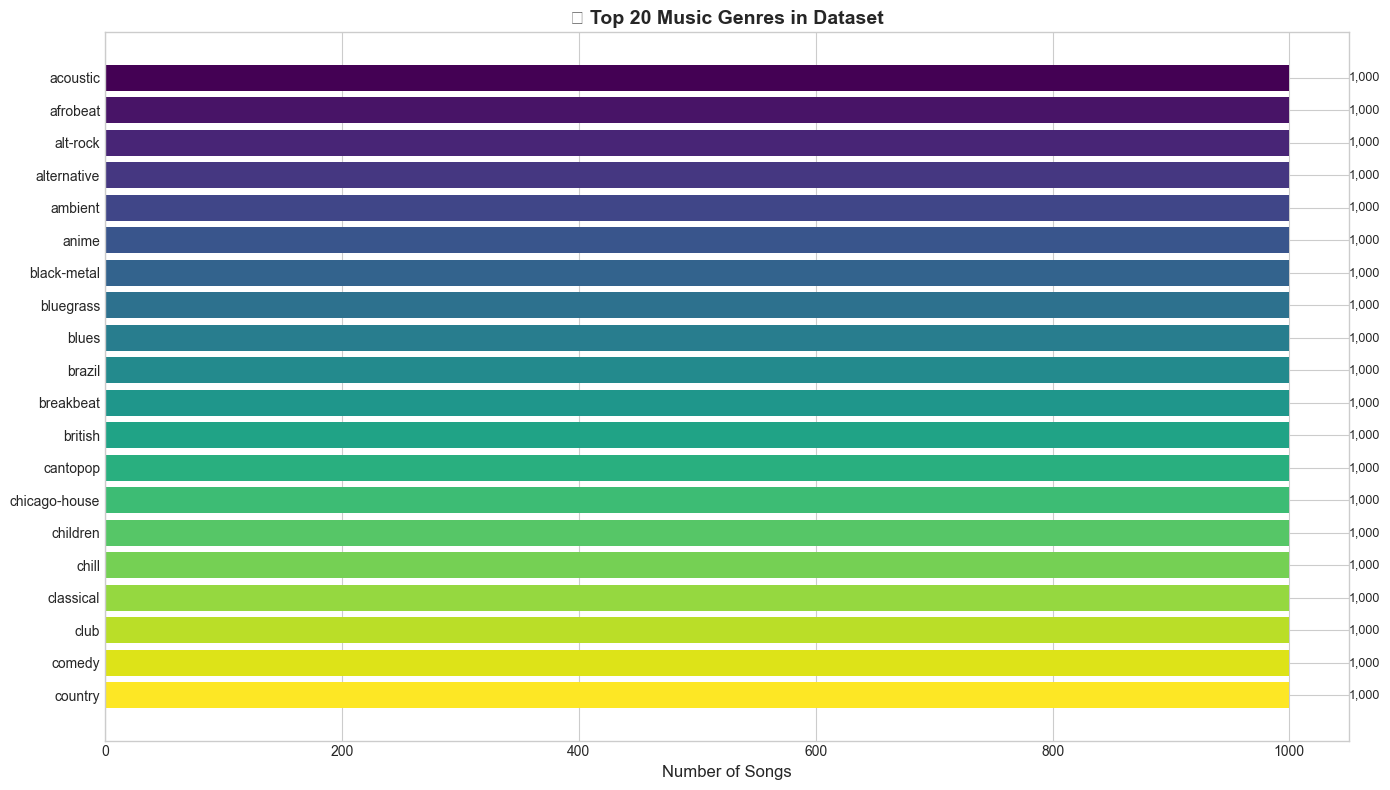


📊 Genre Distribution Statistics:
   Mean songs per genre: 1000
   Std songs per genre: 0
   Min songs per genre: 1000
   Max songs per genre: 1000


In [7]:
# =============================================================================
# GENRE DISTRIBUTION ANALYSIS
# =============================================================================

print("=" * 60)
print("🎼 GENRE DISTRIBUTION ANALYSIS")
print("=" * 60)

# Count genres
genre_counts = df_raw['track_genre'].value_counts()
print(f"\n📊 Total Unique Genres: {len(genre_counts)}")
print(f"📈 Most Common: {genre_counts.index[0]} ({genre_counts.iloc[0]:,} songs)")
print(f"📉 Least Common: {genre_counts.index[-1]} ({genre_counts.iloc[-1]:,} songs)")

# Visualize top 20 genres
fig, ax = plt.subplots(figsize=(14, 8))
top_20_genres = genre_counts.head(20)
colors = plt.cm.viridis(np.linspace(0, 1, 20))

bars = ax.barh(range(len(top_20_genres)), top_20_genres.values, color=colors)
ax.set_yticks(range(len(top_20_genres)))
ax.set_yticklabels(top_20_genres.index)
ax.invert_yaxis()
ax.set_xlabel('Number of Songs', fontsize=12)
ax.set_title('🎵 Top 20 Music Genres in Dataset', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, top_20_genres.values):
    ax.text(val + 50, bar.get_y() + bar.get_height()/2, f'{val:,}', 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Show genre distribution statistics
print("\n📊 Genre Distribution Statistics:")
print(f"   Mean songs per genre: {genre_counts.mean():.0f}")
print(f"   Std songs per genre: {genre_counts.std():.0f}")
print(f"   Min songs per genre: {genre_counts.min()}")
print(f"   Max songs per genre: {genre_counts.max()}")

## 3. 🎯 Stratified Sampling

### Mengapa Stratified Sampling?
- **Random Sampling** dapat menyebabkan genre minoritas hilang atau underrepresented
- **Stratified Sampling** memastikan proporsi setiap genre tetap terjaga
- Dengan 20.000 sampel, kita mendapatkan dataset yang representatif namun efisien untuk komputasi

In [8]:
# =============================================================================
# STRATIFIED SAMPLING - 20,000 SAMPLES
# =============================================================================

SAMPLE_SIZE = 20000

print("=" * 60)
print("🎯 STRATIFIED SAMPLING")
print("=" * 60)

# Clean data first (remove any NaN in features)
df_clean = df_raw.dropna(subset=AUDIO_FEATURES + ['track_genre']).copy()
print(f"\n📊 Data after cleaning: {len(df_clean):,} rows")

# Calculate sampling fraction
sample_fraction = SAMPLE_SIZE / len(df_clean)
print(f"📐 Sampling fraction: {sample_fraction:.4f} ({sample_fraction*100:.2f}%)")

# Perform Stratified Sampling
# Using train_test_split with stratify parameter
df_sample, _ = train_test_split(
    df_clean,
    train_size=SAMPLE_SIZE,
    stratify=df_clean['track_genre'],
    random_state=RANDOM_STATE
)

print(f"\n✅ Stratified Sample Size: {len(df_sample):,} rows")

# Verify stratification worked
print("\n🔍 Verification - Genre proportion comparison:")
original_props = df_clean['track_genre'].value_counts(normalize=True).head(5)
sample_props = df_sample['track_genre'].value_counts(normalize=True).head(5)

comparison = pd.DataFrame({
    'Original (%)': (original_props * 100).round(2),
    'Sample (%)': (sample_props * 100).round(2)
})
comparison['Difference'] = abs(comparison['Original (%)'] - comparison['Sample (%)']).round(2)
print(comparison)
print("\n✅ Stratification successful - proportions maintained!")

🎯 STRATIFIED SAMPLING

📊 Data after cleaning: 114,000 rows
📐 Sampling fraction: 0.1754 (17.54%)

✅ Stratified Sample Size: 20,000 rows

🔍 Verification - Genre proportion comparison:
             Original (%)  Sample (%)  Difference
track_genre                                      
acoustic           0.8800         NaN         NaN
afrobeat           0.8800         NaN         NaN
alt-rock           0.8800         NaN         NaN
alternative        0.8800         NaN         NaN
ambient            0.8800         NaN         NaN
classical             NaN      0.8800         NaN
grindcore             NaN      0.8800         NaN
jazz                  NaN      0.8800         NaN
spanish               NaN      0.8800         NaN
tango                 NaN      0.8800         NaN

✅ Stratification successful - proportions maintained!


## 4. 📊 Exploratory Data Analysis (EDA)

### Analisis Distribusi Fitur Audio
Sebelum preprocessing, penting untuk memahami karakteristik setiap fitur:
- **Skewness**: Mengukur kemiringan distribusi
- Fitur dengan |skewness| > 1 dianggap highly skewed dan memerlukan transformasi

In [9]:
# =============================================================================
# DESCRIPTIVE STATISTICS
# =============================================================================

print("=" * 60)
print("📊 DESCRIPTIVE STATISTICS - AUDIO FEATURES")
print("=" * 60)

# Get statistics for audio features
stats_df = df_sample[AUDIO_FEATURES].describe().T
stats_df['skewness'] = df_sample[AUDIO_FEATURES].apply(skew)
stats_df['kurtosis'] = df_sample[AUDIO_FEATURES].apply(lambda x: stats.kurtosis(x))

# Flag highly skewed features
stats_df['is_skewed'] = stats_df['skewness'].abs() > 1

print("\n📈 Feature Statistics:")
display(stats_df.round(4))

# Identify skewed features
skewed_features = stats_df[stats_df['is_skewed']].index.tolist()
print(f"\n⚠️ Highly Skewed Features (|skewness| > 1):")
for feat in skewed_features:
    sk_val = stats_df.loc[feat, 'skewness']
    print(f"   • {feat}: skewness = {sk_val:.3f}")

📊 DESCRIPTIVE STATISTICS - AUDIO FEATURES

📈 Feature Statistics:


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis,is_skewed
danceability,20000.0000,0.5665,0.1733,0.0000,0.4560,0.5790,0.6950,0.9810,-0.3927,-0.1878,False
energy,20000.0000,0.6397,0.2525,0.0000,0.4670,0.6835,0.8530,1.0000,-0.5840,-0.5535,False
loudness,20000.0000,-8.2811,5.0400,-46.2510,-10.0880,-7.0075,-5.0190,1.6730,-1.9522,5.5528,True
speechiness,20000.0000,0.0846,0.1058,0.0000,0.0359,0.0489,0.0848,0.9650,4.6966,29.3651,True
acousticness,20000.0000,0.3171,0.3335,0.0000,0.0170,0.1720,0.6040,0.9960,0.7146,-0.9739,False
instrumentalness,20000.0000,0.1538,0.3066,0.0000,0.0000,0.0000,0.0460,1.0000,1.7568,1.3610,True
liveness,20000.0000,0.2109,0.1880,0.0000,0.0976,0.1300,0.2710,0.9940,2.1426,4.6134,True
valence,20000.0000,0.4724,0.2584,0.0000,0.2590,0.4615,0.6810,0.9930,0.1185,-1.0206,False
tempo,20000.0000,122.0963,29.7732,0.0000,99.3285,122.0245,140.0312,220.0840,0.2303,-0.0971,False



⚠️ Highly Skewed Features (|skewness| > 1):
   • loudness: skewness = -1.952
   • speechiness: skewness = 4.697
   • instrumentalness: skewness = 1.757
   • liveness: skewness = 2.143


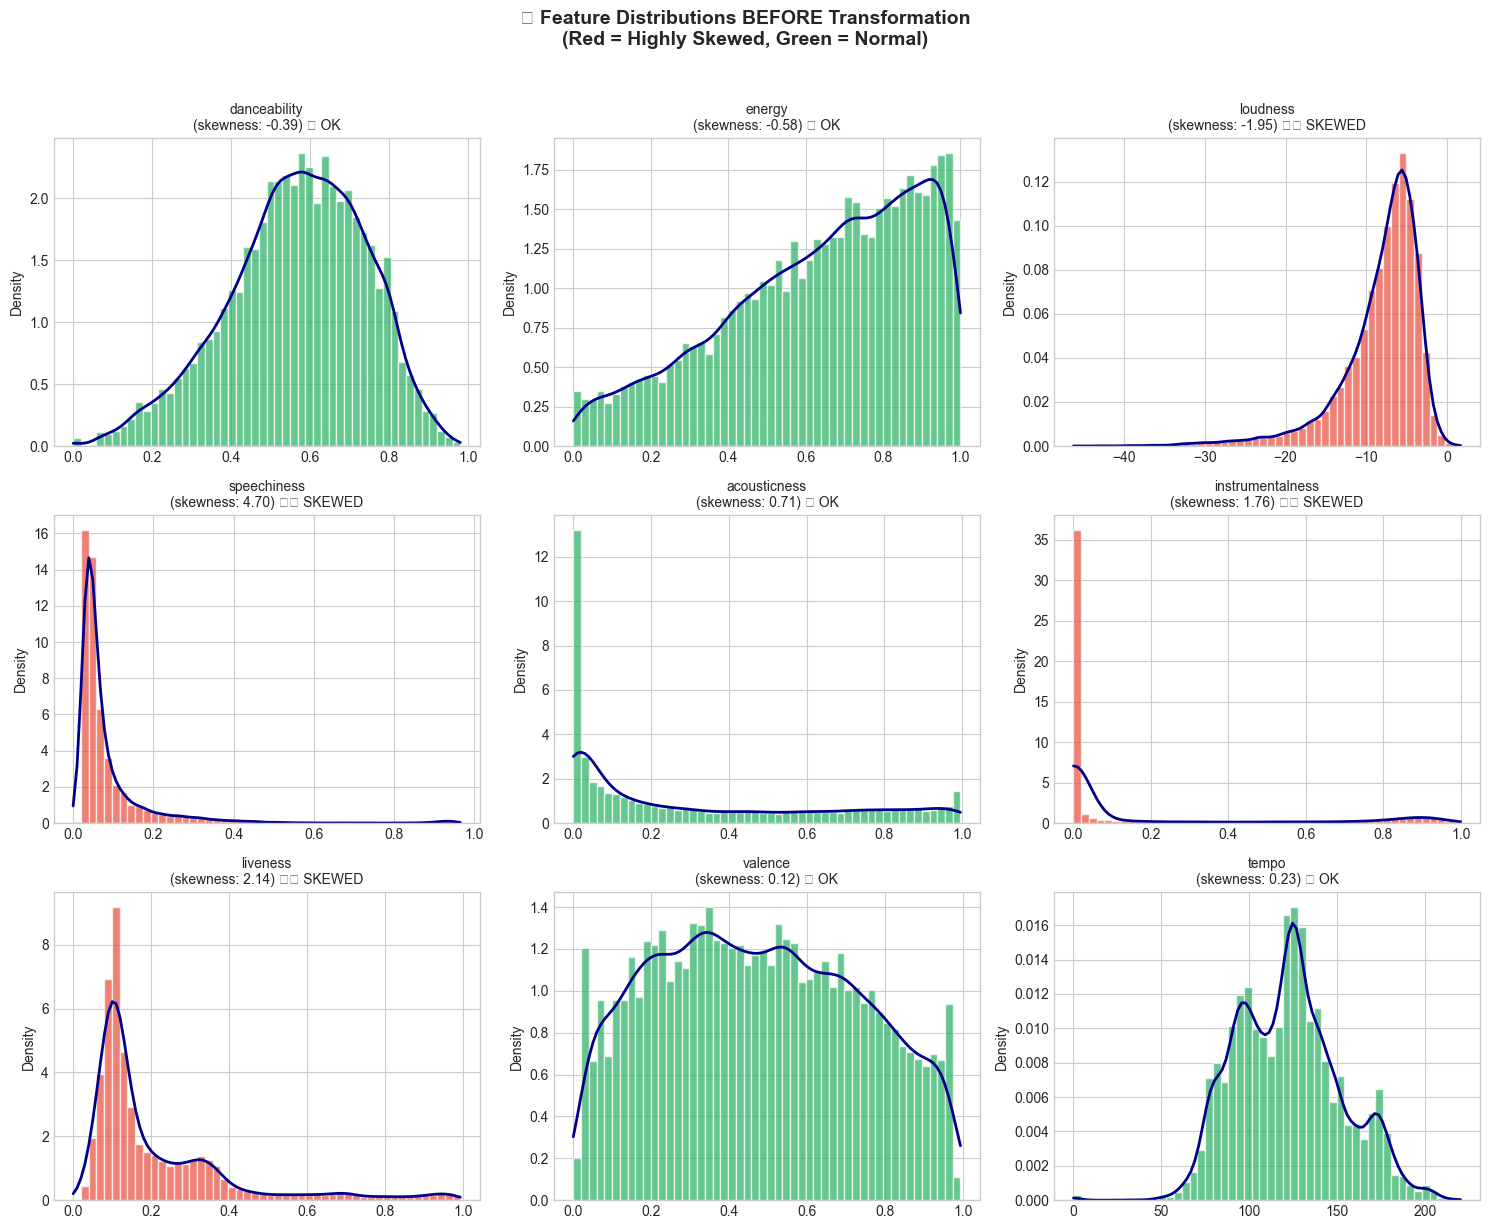

In [10]:
# =============================================================================
# DISTRIBUTION VISUALIZATION - BEFORE TRANSFORMATION
# =============================================================================

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, feature in enumerate(AUDIO_FEATURES):
    ax = axes[idx]
    
    # Histogram with KDE
    data = df_sample[feature].dropna()
    
    # Color coding: red for skewed, green for normal
    is_skewed = feature in skewed_features
    color = '#e74c3c' if is_skewed else '#27ae60'
    
    ax.hist(data, bins=50, density=True, alpha=0.7, color=color, edgecolor='white')
    
    # Add KDE
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 100)
        ax.plot(x_range, kde(x_range), color='darkblue', linewidth=2)
    except:
        pass
    
    # Title with skewness value
    sk_val = skew(data)
    status = "⚠️ SKEWED" if is_skewed else "✅ OK"
    ax.set_title(f'{feature}\n(skewness: {sk_val:.2f}) {status}', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('Density')

plt.suptitle('📊 Feature Distributions BEFORE Transformation\n(Red = Highly Skewed, Green = Normal)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

🔗 CORRELATION ANALYSIS


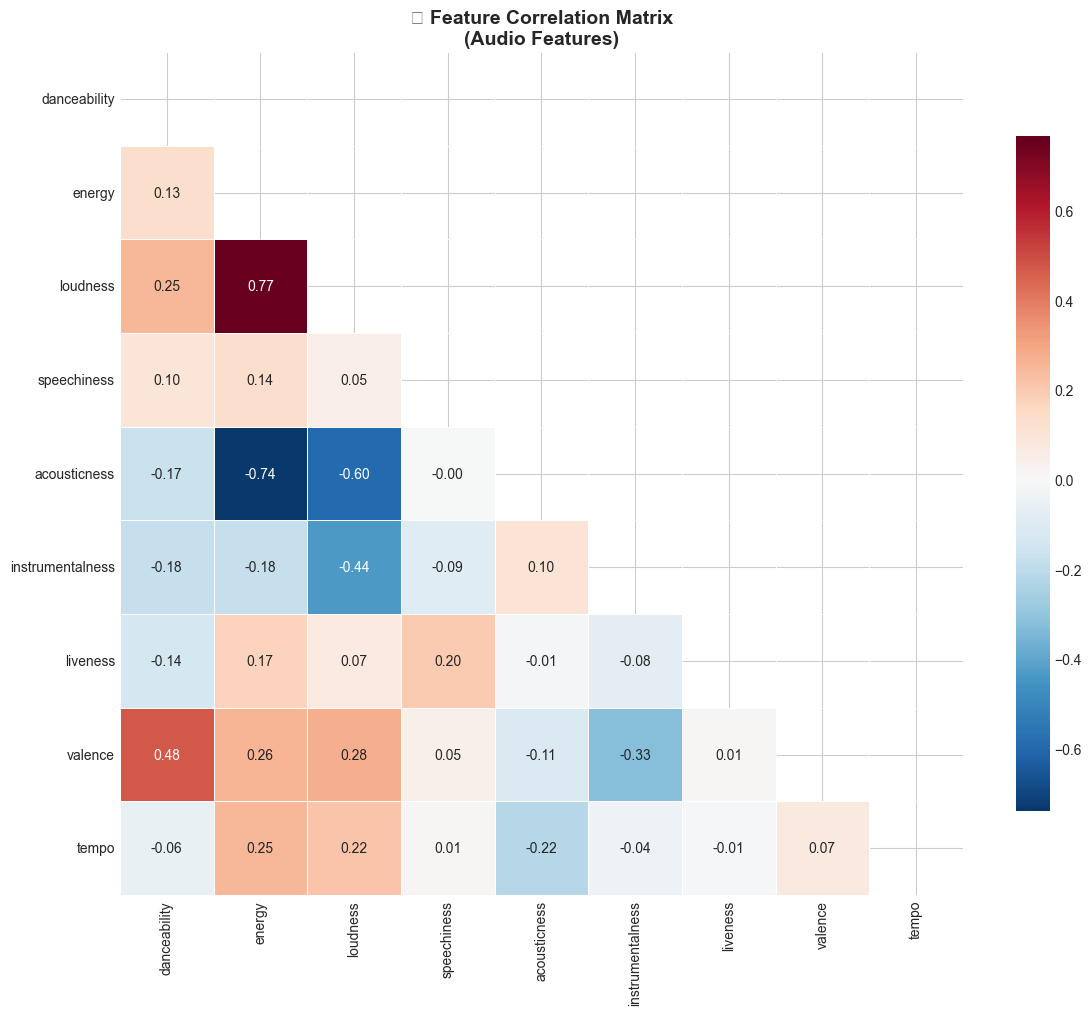


📊 Highly Correlated Feature Pairs (|r| > 0.5):
   • energy ↔ loudness: 0.765 (positive)
   • energy ↔ acousticness: -0.739 (negative)
   • loudness ↔ acousticness: -0.595 (negative)


In [11]:
# =============================================================================
# CORRELATION ANALYSIS
# =============================================================================

print("=" * 60)
print("🔗 CORRELATION ANALYSIS")
print("=" * 60)

# Calculate correlation matrix
corr_matrix = df_sample[AUDIO_FEATURES].corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8},
            ax=ax)

ax.set_title('🔗 Feature Correlation Matrix\n(Audio Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated pairs
print("\n📊 Highly Correlated Feature Pairs (|r| > 0.5):")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.5:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                            corr_matrix.iloc[i, j]))

for feat1, feat2, corr_val in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
    direction = "positive" if corr_val > 0 else "negative"
    print(f"   • {feat1} ↔ {feat2}: {corr_val:.3f} ({direction})")

## 5. 🔧 Advanced Preprocessing

### Strategi Preprocessing:
1. **Power Transform (Yeo-Johnson)** untuk fitur skewed
   - Yeo-Johnson dipilih karena dapat menangani nilai negatif (seperti loudness)
   - Tujuan: Mendekatkan distribusi ke Gaussian (normal)
   
2. **Standard Scaling** setelah transformasi
   - K-Means berbasis jarak Euclidean, sensitif terhadap skala
   - StandardScaler: mean=0, std=1

### ⚠️ Mengapa Ini Penting?
Algoritma berbasis jarak seperti K-Means bekerja buruk pada data yang sangat miring karena:
- Outlier mendominasi perhitungan centroid
- Jarak antar titik menjadi tidak representatif
- Cluster cenderung terbentuk berdasarkan outlier, bukan pola sebenarnya

In [12]:
# =============================================================================
# ADVANCED PREPROCESSING PIPELINE
# =============================================================================

print("=" * 60)
print("🔧 ADVANCED PREPROCESSING PIPELINE")
print("=" * 60)

# Extract features for transformation
X_raw = df_sample[AUDIO_FEATURES].copy()

# Step 1: Power Transform (Yeo-Johnson) for ALL features
# Yeo-Johnson can handle negative values (unlike Box-Cox)
print("\n📌 Step 1: Applying Power Transform (Yeo-Johnson)...")

power_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
X_power_transformed = power_transformer.fit_transform(X_raw)
X_power_df = pd.DataFrame(X_power_transformed, columns=AUDIO_FEATURES, index=X_raw.index)

# Check skewness after power transform
skewness_after_power = X_power_df.apply(skew)
print("\n📊 Skewness AFTER Power Transform:")
for feat in AUDIO_FEATURES:
    before = skew(X_raw[feat])
    after = skewness_after_power[feat]
    improvement = abs(before) - abs(after)
    status = "✅" if abs(after) < 1 else "⚠️"
    print(f"   {status} {feat}: {before:.3f} → {after:.3f} (improvement: {improvement:.3f})")

# Step 2: Standard Scaling
print("\n📌 Step 2: Applying Standard Scaler...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_power_df)
X_scaled_df = pd.DataFrame(X_scaled, columns=AUDIO_FEATURES, index=X_raw.index)

print("\n✅ Preprocessing complete!")
print(f"   Final shape: {X_scaled_df.shape}")

🔧 ADVANCED PREPROCESSING PIPELINE

📌 Step 1: Applying Power Transform (Yeo-Johnson)...

📊 Skewness AFTER Power Transform:
   ✅ danceability: -0.393 → -0.043 (improvement: 0.349)
   ✅ energy: -0.584 → -0.166 (improvement: 0.418)
   ✅ loudness: -1.952 → 0.010 (improvement: 1.942)
   ✅ speechiness: 4.697 → 0.668 (improvement: 4.029)
   ✅ acousticness: 0.715 → 0.245 (improvement: 0.469)
   ⚠️ instrumentalness: 1.757 → 1.270 (improvement: 0.487)
   ✅ liveness: 2.143 → 0.373 (improvement: 1.770)
   ✅ valence: 0.119 → -0.027 (improvement: 0.092)
   ✅ tempo: 0.230 → 0.061 (improvement: 0.170)

📌 Step 2: Applying Standard Scaler...

✅ Preprocessing complete!
   Final shape: (20000, 9)


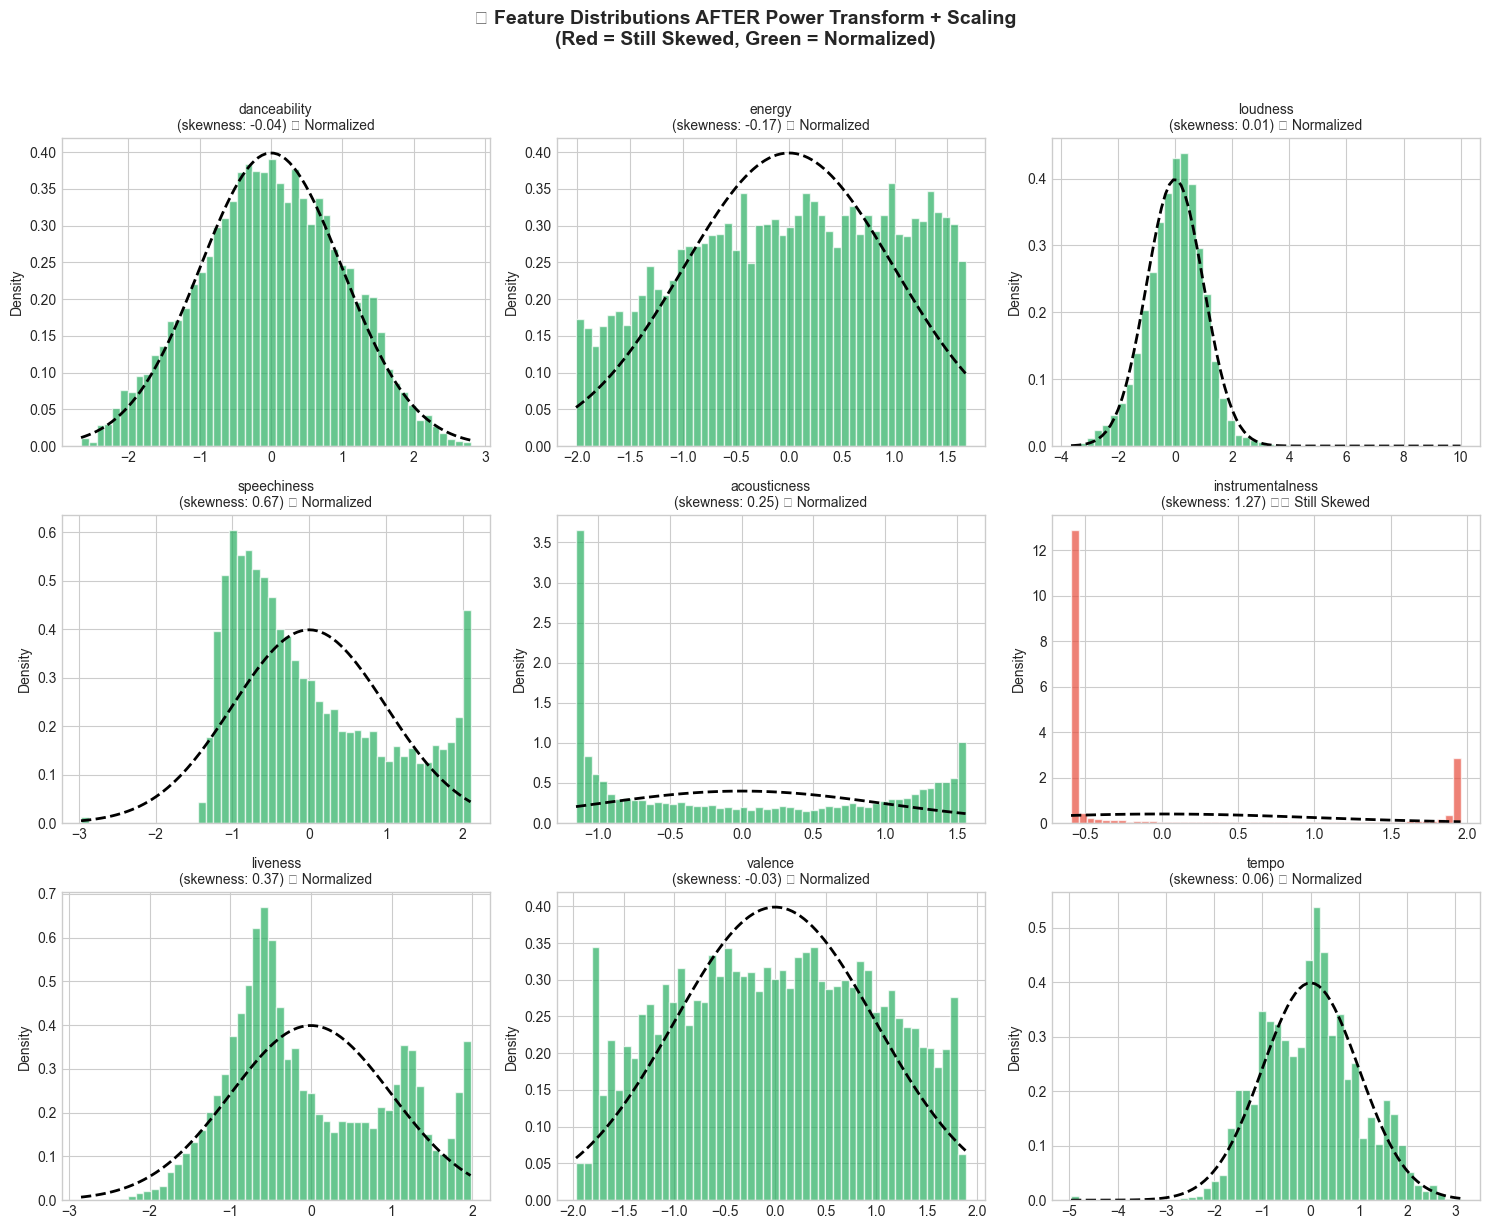

In [13]:
# =============================================================================
# DISTRIBUTION VISUALIZATION - AFTER TRANSFORMATION
# =============================================================================

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, feature in enumerate(AUDIO_FEATURES):
    ax = axes[idx]
    
    # Get transformed data
    data = X_scaled_df[feature].dropna()
    
    # Check if still skewed
    sk_val = skew(data)
    is_still_skewed = abs(sk_val) > 1
    color = '#e74c3c' if is_still_skewed else '#27ae60'
    
    ax.hist(data, bins=50, density=True, alpha=0.7, color=color, edgecolor='white')
    
    # Add normal distribution overlay for comparison
    x_range = np.linspace(data.min(), data.max(), 100)
    ax.plot(x_range, stats.norm.pdf(x_range, data.mean(), data.std()), 
            'k--', linewidth=2, label='Normal')
    
    status = "⚠️ Still Skewed" if is_still_skewed else "✅ Normalized"
    ax.set_title(f'{feature}\n(skewness: {sk_val:.2f}) {status}', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('Density')

plt.suptitle('📊 Feature Distributions AFTER Power Transform + Scaling\n(Red = Still Skewed, Green = Normalized)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. 🎯 K-Means Clustering: Statistical vs Business Optimum

### Pendekatan Dua Perspektif:
1. **Statistical Optimum**: K yang menghasilkan Silhouette Score tertinggi
2. **Business Optimum**: K yang menghasilkan segmen bermakna untuk industri musik

### ⚠️ Masalah Umum:
- Metrik statistik sering menyarankan K=2 atau K=3 (terlalu sedikit untuk genre musik)
- Segmen yang terlalu sedikit tidak actionable untuk bisnis
- Perlu balance antara metrik dan interpretabilitas

In [14]:
# =============================================================================
# ELBOW METHOD & SILHOUETTE ANALYSIS
# =============================================================================

print("=" * 60)
print("🎯 K-MEANS: ELBOW METHOD & SILHOUETTE ANALYSIS")
print("=" * 60)

# Range of K to test
K_range = range(2, 15)

# Storage for metrics
inertias = []
silhouette_scores = []

print("\n🔄 Evaluating K values...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10, max_iter=300)
    kmeans.fit(X_scaled)
    
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    
    print(f"   K={k:2d} | Inertia: {kmeans.inertia_:,.0f} | Silhouette: {sil_score:.4f}")

# Find optimal K based on silhouette
optimal_k_statistical = K_range[np.argmax(silhouette_scores)]
print(f"\n📊 Statistical Optimal K (highest Silhouette): {optimal_k_statistical}")
print(f"   Silhouette Score: {max(silhouette_scores):.4f}")

🎯 K-MEANS: ELBOW METHOD & SILHOUETTE ANALYSIS

🔄 Evaluating K values...
   K= 2 | Inertia: 141,744 | Silhouette: 0.2015
   K= 3 | Inertia: 125,209 | Silhouette: 0.1613
   K= 4 | Inertia: 114,919 | Silhouette: 0.1571
   K= 5 | Inertia: 106,103 | Silhouette: 0.1625
   K= 6 | Inertia: 99,047 | Silhouette: 0.1593
   K= 7 | Inertia: 94,152 | Silhouette: 0.1531
   K= 8 | Inertia: 90,297 | Silhouette: 0.1475
   K= 9 | Inertia: 86,713 | Silhouette: 0.1535
   K=10 | Inertia: 83,747 | Silhouette: 0.1503
   K=11 | Inertia: 81,116 | Silhouette: 0.1458
   K=12 | Inertia: 78,851 | Silhouette: 0.1458
   K=13 | Inertia: 76,557 | Silhouette: 0.1420
   K=14 | Inertia: 74,655 | Silhouette: 0.1402

📊 Statistical Optimal K (highest Silhouette): 2
   Silhouette Score: 0.2015


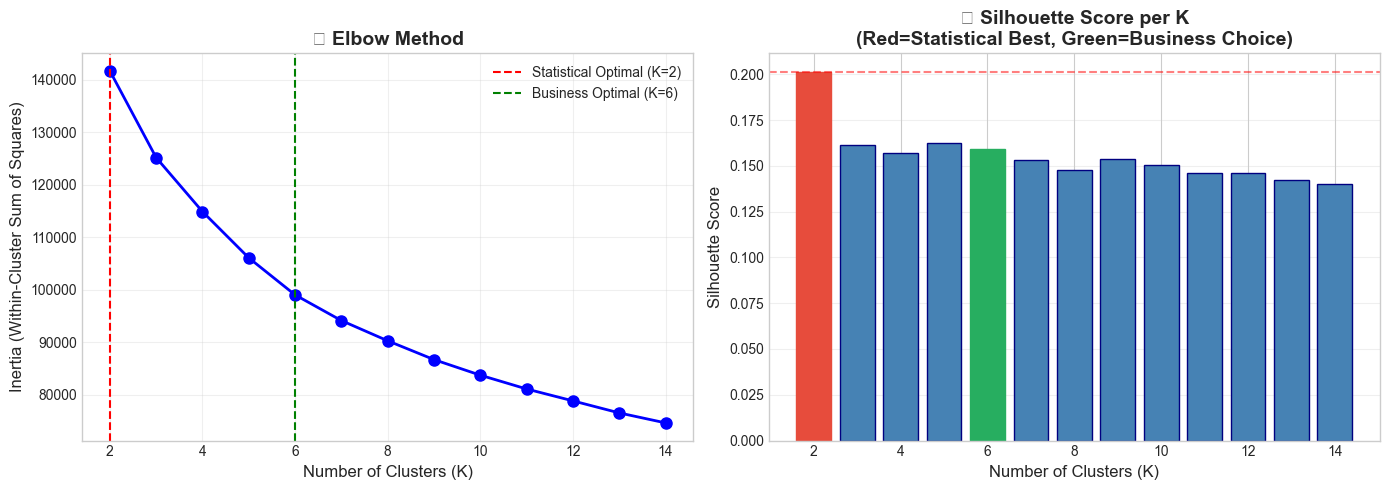


📊 COMPARISON: STATISTICAL vs BUSINESS OPTIMAL

🔴 Statistical Optimal: K = 2
   Silhouette Score: 0.2015

🟢 Business Optimal: K = 6
   Silhouette Score: 0.1593

📉 Score difference: 0.0422


In [15]:
# =============================================================================
# VISUALIZATION: ELBOW & SILHOUETTE
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Plot
ax1 = axes[0]
ax1.plot(list(K_range), inertias, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=optimal_k_statistical, color='r', linestyle='--', 
            label=f'Statistical Optimal (K={optimal_k_statistical})')
ax1.axvline(x=6, color='g', linestyle='--', 
            label='Business Optimal (K=6)')
ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
ax1.set_title('📉 Elbow Method', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Silhouette Plot
ax2 = axes[1]
bars = ax2.bar(list(K_range), silhouette_scores, color='steelblue', edgecolor='navy')

# Highlight optimal
bars[optimal_k_statistical - 2].set_color('#e74c3c')  # Statistical optimal
if 6 in K_range:
    bars[4].set_color('#27ae60')  # Business optimal (K=6, index 4)

ax2.axhline(y=max(silhouette_scores), color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of Clusters (K)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('📊 Silhouette Score per K\n(Red=Statistical Best, Green=Business Choice)', 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print comparison
print("\n" + "=" * 60)
print("📊 COMPARISON: STATISTICAL vs BUSINESS OPTIMAL")
print("=" * 60)
print(f"\n🔴 Statistical Optimal: K = {optimal_k_statistical}")
print(f"   Silhouette Score: {silhouette_scores[optimal_k_statistical-2]:.4f}")
print(f"\n🟢 Business Optimal: K = 6")
print(f"   Silhouette Score: {silhouette_scores[4]:.4f}")
print(f"\n📉 Score difference: {silhouette_scores[optimal_k_statistical-2] - silhouette_scores[4]:.4f}")

In [16]:
# =============================================================================
# TRAIN BOTH MODELS: STATISTICAL vs BUSINESS
# =============================================================================

print("=" * 60)
print("🎯 TRAINING K-MEANS MODELS")
print("=" * 60)

# Model 1: Statistical Optimal
K_STATISTICAL = optimal_k_statistical
kmeans_statistical = KMeans(n_clusters=K_STATISTICAL, random_state=RANDOM_STATE, 
                           n_init=10, max_iter=300)
labels_statistical = kmeans_statistical.fit_predict(X_scaled)

print(f"\n🔴 Model 1: Statistical Optimal (K={K_STATISTICAL})")
print(f"   Silhouette Score: {silhouette_score(X_scaled, labels_statistical):.4f}")
print(f"   Cluster distribution:")
for i, count in enumerate(np.bincount(labels_statistical)):
    print(f"     Cluster {i}: {count:,} songs ({count/len(labels_statistical)*100:.1f}%)")

# Model 2: Business Optimal
K_BUSINESS = 6
kmeans_business = KMeans(n_clusters=K_BUSINESS, random_state=RANDOM_STATE, 
                        n_init=10, max_iter=300)
labels_business = kmeans_business.fit_predict(X_scaled)

print(f"\n🟢 Model 2: Business Optimal (K={K_BUSINESS})")
print(f"   Silhouette Score: {silhouette_score(X_scaled, labels_business):.4f}")
print(f"   Cluster distribution:")
for i, count in enumerate(np.bincount(labels_business)):
    print(f"     Cluster {i}: {count:,} songs ({count/len(labels_business)*100:.1f}%)")

🎯 TRAINING K-MEANS MODELS

🔴 Model 1: Statistical Optimal (K=2)
   Silhouette Score: 0.2015
   Cluster distribution:
     Cluster 0: 12,641 songs (63.2%)
     Cluster 1: 7,359 songs (36.8%)

🟢 Model 2: Business Optimal (K=6)
   Silhouette Score: 0.1593
   Cluster distribution:
     Cluster 0: 2,545 songs (12.7%)
     Cluster 1: 3,818 songs (19.1%)
     Cluster 2: 2,882 songs (14.4%)
     Cluster 3: 4,409 songs (22.0%)
     Cluster 4: 1,754 songs (8.8%)
     Cluster 5: 4,592 songs (23.0%)


In [17]:
# =============================================================================
# PCA FOR VISUALIZATION (2D)
# =============================================================================

print("=" * 60)
print("📊 PCA FOR VISUALIZATION")
print("=" * 60)

# Apply PCA for 2D visualization
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"\n📐 PCA 2D - Explained Variance:")
print(f"   PC1: {pca_2d.explained_variance_ratio_[0]*100:.2f}%")
print(f"   PC2: {pca_2d.explained_variance_ratio_[1]*100:.2f}%")
print(f"   Total: {sum(pca_2d.explained_variance_ratio_)*100:.2f}%")

# Create DataFrame for plotting
df_pca_viz = pd.DataFrame({
    'PC1': X_pca_2d[:, 0],
    'PC2': X_pca_2d[:, 1],
    'Cluster_Statistical': labels_statistical,
    'Cluster_Business': labels_business,
    'Genre': df_sample['track_genre'].values
})

📊 PCA FOR VISUALIZATION

📐 PCA 2D - Explained Variance:
   PC1: 30.91%
   PC2: 17.32%
   Total: 48.23%


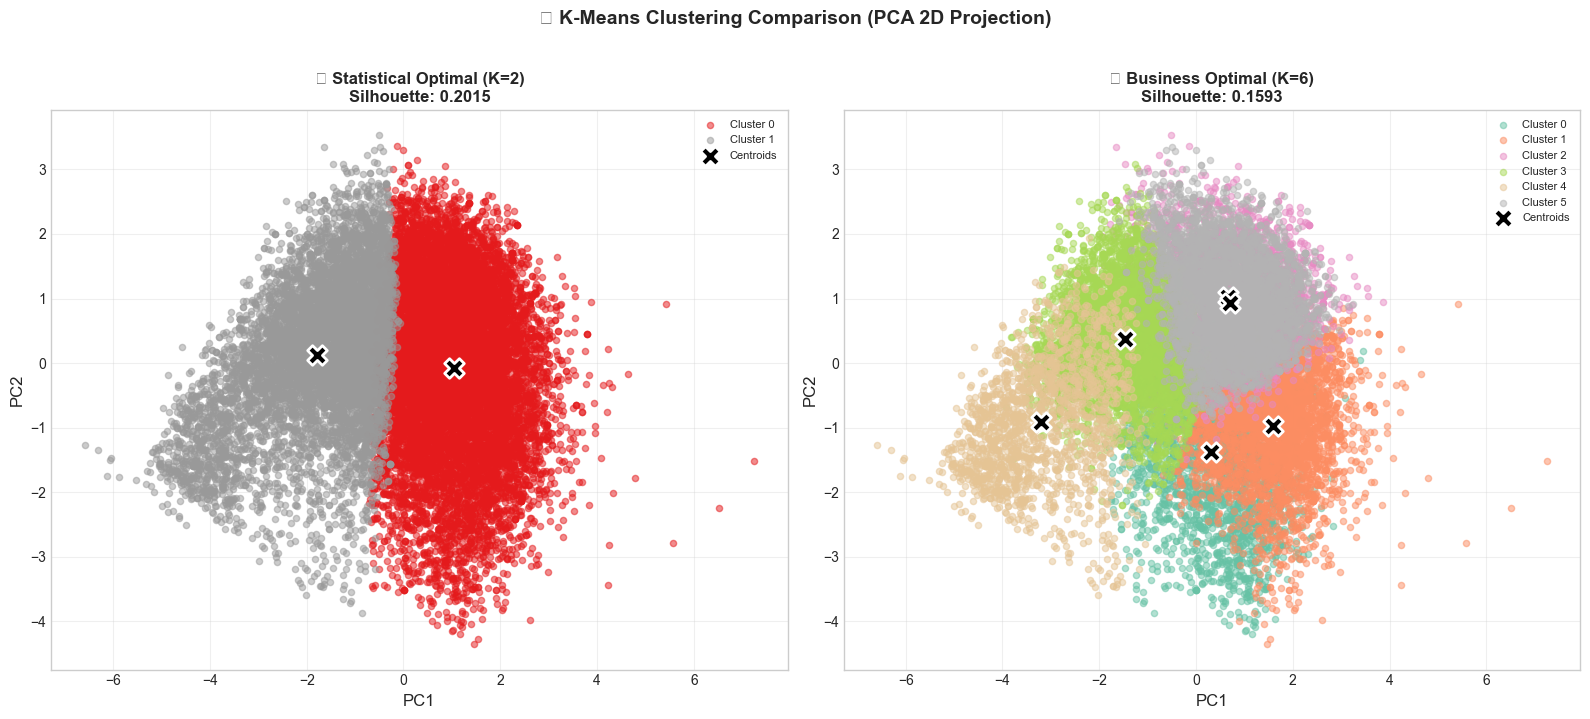

In [18]:
# =============================================================================
# VISUALIZATION: STATISTICAL vs BUSINESS CLUSTERS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Define colors
colors_stat = plt.cm.Set1(np.linspace(0, 1, K_STATISTICAL))
colors_bus = plt.cm.Set2(np.linspace(0, 1, K_BUSINESS))

# Plot Statistical Optimal
ax1 = axes[0]
for cluster in range(K_STATISTICAL):
    mask = labels_statistical == cluster
    ax1.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
               c=[colors_stat[cluster]], label=f'Cluster {cluster}',
               alpha=0.5, s=20)
# Plot centroids
centroids_stat = pca_2d.transform(kmeans_statistical.cluster_centers_)
ax1.scatter(centroids_stat[:, 0], centroids_stat[:, 1], 
           c='black', marker='X', s=200, edgecolors='white', linewidths=2,
           label='Centroids')
ax1.set_xlabel('PC1', fontsize=12)
ax1.set_ylabel('PC2', fontsize=12)
ax1.set_title(f'🔴 Statistical Optimal (K={K_STATISTICAL})\nSilhouette: {silhouette_score(X_scaled, labels_statistical):.4f}', 
              fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot Business Optimal
ax2 = axes[1]
for cluster in range(K_BUSINESS):
    mask = labels_business == cluster
    ax2.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
               c=[colors_bus[cluster]], label=f'Cluster {cluster}',
               alpha=0.5, s=20)
# Plot centroids
centroids_bus = pca_2d.transform(kmeans_business.cluster_centers_)
ax2.scatter(centroids_bus[:, 0], centroids_bus[:, 1], 
           c='black', marker='X', s=200, edgecolors='white', linewidths=2,
           label='Centroids')
ax2.set_xlabel('PC1', fontsize=12)
ax2.set_ylabel('PC2', fontsize=12)
ax2.set_title(f'🟢 Business Optimal (K={K_BUSINESS})\nSilhouette: {silhouette_score(X_scaled, labels_business):.4f}', 
              fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)

plt.suptitle('📊 K-Means Clustering Comparison (PCA 2D Projection)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 7. 📡 DBSCAN Clustering with PCA

### Masalah "Giant Blob" pada DBSCAN
Ketika DBSCAN diterapkan langsung pada fitur audio berdimensi tinggi:
- Sering menghasilkan **satu cluster raksasa** (90%+ data)
- Sisanya dianggap noise (-1)
- Ini terjadi karena "curse of dimensionality"

### Solusi: PCA sebelum DBSCAN
1. Reduksi dimensi ke 2-3 komponen utama
2. PCA membantu menghilangkan noise dan multikolinearitas
3. DBSCAN bekerja lebih baik pada ruang berdimensi rendah

In [19]:
# =============================================================================
# PCA FOR DBSCAN (3 COMPONENTS)
# =============================================================================

print("=" * 60)
print("📡 PCA FOR DBSCAN")
print("=" * 60)

# Apply PCA with 3 components for DBSCAN
pca_3d = PCA(n_components=3, random_state=RANDOM_STATE)
X_pca_3d = pca_3d.fit_transform(X_scaled)

print(f"\n📐 PCA 3D - Explained Variance:")
for i, var in enumerate(pca_3d.explained_variance_ratio_):
    print(f"   PC{i+1}: {var*100:.2f}%")
print(f"   Total: {sum(pca_3d.explained_variance_ratio_)*100:.2f}%")

# Show loadings (feature contributions to each PC)
print("\n📊 Feature Loadings (Top contributors to each PC):")
loadings = pd.DataFrame(
    pca_3d.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=AUDIO_FEATURES
)
for pc in ['PC1', 'PC2', 'PC3']:
    top_features = loadings[pc].abs().nlargest(3).index.tolist()
    print(f"   {pc}: {', '.join(top_features)}")

📡 PCA FOR DBSCAN

📐 PCA 3D - Explained Variance:
   PC1: 30.91%
   PC2: 17.32%
   PC3: 12.22%
   Total: 60.45%

📊 Feature Loadings (Top contributors to each PC):
   PC1: energy, loudness, acousticness
   PC2: danceability, valence, instrumentalness
   PC3: liveness, instrumentalness, danceability


In [20]:
# =============================================================================
# DBSCAN WITHOUT PCA (Demonstration of "Giant Blob" problem)
# =============================================================================

print("=" * 60)
print("⚠️ DBSCAN WITHOUT PCA (Giant Blob Demonstration)")
print("=" * 60)

# Run DBSCAN on original scaled data
dbscan_no_pca = DBSCAN(eps=1.5, min_samples=50)
labels_no_pca = dbscan_no_pca.fit_predict(X_scaled)

n_clusters_no_pca = len(set(labels_no_pca)) - (1 if -1 in labels_no_pca else 0)
noise_count = list(labels_no_pca).count(-1)
noise_pct = noise_count / len(labels_no_pca) * 100

print(f"\n🔍 Results WITHOUT PCA:")
print(f"   Number of clusters: {n_clusters_no_pca}")
print(f"   Noise points: {noise_count:,} ({noise_pct:.1f}%)")

# Show cluster distribution
print("\n📊 Cluster Distribution:")
for label in sorted(set(labels_no_pca)):
    count = list(labels_no_pca).count(label)
    pct = count / len(labels_no_pca) * 100
    label_name = "Noise" if label == -1 else f"Cluster {label}"
    if pct > 50:
        print(f"   ⚠️ {label_name}: {count:,} ({pct:.1f}%) <- GIANT BLOB!")
    else:
        print(f"   {label_name}: {count:,} ({pct:.1f}%)")

⚠️ DBSCAN WITHOUT PCA (Giant Blob Demonstration)

🔍 Results WITHOUT PCA:
   Number of clusters: 1
   Noise points: 1,086 (5.4%)

📊 Cluster Distribution:
   Noise: 1,086 (5.4%)
   ⚠️ Cluster 0: 18,914 (94.6%) <- GIANT BLOB!


In [21]:
# =============================================================================
# DBSCAN PARAMETER TUNING ON PCA DATA
# =============================================================================

print("=" * 60)
print("🔧 DBSCAN PARAMETER TUNING (on PCA 3D)")
print("=" * 60)

# Parameter grid for tuning
eps_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
min_samples_values = [20, 30, 50, 75, 100]

results = []

print("\n🔄 Testing parameter combinations...")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_pca_3d)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_pct = list(labels).count(-1) / len(labels) * 100
        
        # Calculate silhouette only if we have valid clusters
        if n_clusters > 1 and noise_pct < 90:
            # Exclude noise for silhouette calculation
            mask = labels != -1
            if len(set(labels[mask])) > 1:
                sil = silhouette_score(X_pca_3d[mask], labels[mask])
            else:
                sil = -1
        else:
            sil = -1
        
        # Check for giant blob (any cluster > 70%)
        if n_clusters > 0:
            cluster_sizes = [list(labels).count(i) for i in range(n_clusters)]
            max_cluster_pct = max(cluster_sizes) / (len(labels) - list(labels).count(-1)) * 100 if n_clusters > 0 else 0
        else:
            max_cluster_pct = 0
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'noise_pct': noise_pct,
            'max_cluster_pct': max_cluster_pct,
            'silhouette': sil
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Filter for reasonable results (multiple clusters, not too much noise, no giant blob)
good_results = results_df[
    (results_df['n_clusters'] >= 3) & 
    (results_df['noise_pct'] < 30) & 
    (results_df['max_cluster_pct'] < 70) &
    (results_df['silhouette'] > 0)
].sort_values('silhouette', ascending=False)

print("\n📊 Top 5 Parameter Combinations:")
if len(good_results) > 0:
    display(good_results.head(10))
else:
    print("No ideal combination found. Showing best available:")
    display(results_df.nlargest(5, 'silhouette'))

🔧 DBSCAN PARAMETER TUNING (on PCA 3D)

🔄 Testing parameter combinations...

📊 Top 5 Parameter Combinations:
No ideal combination found. Showing best available:


,eps,min_samples,n_clusters,noise_pct,max_cluster_pct,silhouette
8,0.4000,75,3,39.0100,97.6881,0.4982
13,0.5000,75,2,14.3300,94.7940,0.4213
14,0.5000,100,3,23.1450,95.5305,0.3259
15,0.6000,20,2,0.5850,99.8743,0.2792
7,0.4000,50,4,23.9100,94.1319,0.1855


In [22]:
# =============================================================================
# FINAL DBSCAN MODEL WITH OPTIMAL PARAMETERS
# =============================================================================

print("=" * 60)
print("📡 FINAL DBSCAN MODEL (PCA 3D)")
print("=" * 60)

# Select best parameters (or use reasonable defaults if no good combination found)
if len(good_results) > 0:
    best_eps = good_results.iloc[0]['eps']
    best_min_samples = int(good_results.iloc[0]['min_samples'])
else:
    # Fallback to reasonable defaults for music data
    best_eps = 0.5
    best_min_samples = 30

print(f"\n🎯 Selected Parameters:")
print(f"   eps: {best_eps}")
print(f"   min_samples: {best_min_samples}")

# Fit final DBSCAN model
dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_dbscan = dbscan_final.fit_predict(X_pca_3d)

n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
noise_count_dbscan = list(labels_dbscan).count(-1)

print(f"\n📊 Results:")
print(f"   Number of clusters: {n_clusters_dbscan}")
print(f"   Noise points: {noise_count_dbscan:,} ({noise_count_dbscan/len(labels_dbscan)*100:.1f}%)")

# Calculate silhouette (excluding noise)
mask_dbscan = labels_dbscan != -1
if len(set(labels_dbscan[mask_dbscan])) > 1:
    sil_dbscan = silhouette_score(X_pca_3d[mask_dbscan], labels_dbscan[mask_dbscan])
    print(f"   Silhouette Score (excl. noise): {sil_dbscan:.4f}")

# Cluster distribution
print("\n📊 Cluster Distribution:")
for label in sorted(set(labels_dbscan)):
    count = list(labels_dbscan).count(label)
    pct = count / len(labels_dbscan) * 100
    label_name = "Noise (-1)" if label == -1 else f"Cluster {label}"
    print(f"   {label_name}: {count:,} ({pct:.1f}%)")

📡 FINAL DBSCAN MODEL (PCA 3D)

🎯 Selected Parameters:
   eps: 0.5
   min_samples: 30

📊 Results:
   Number of clusters: 1
   Noise points: 672 (3.4%)

📊 Cluster Distribution:
   Noise (-1): 672 (3.4%)
   Cluster 0: 19,328 (96.6%)


In [23]:
# =============================================================================
# DBSCAN VISUALIZATION (3D)
# =============================================================================

# Create 3D scatter plot using Plotly
fig = go.Figure()

# Define colors for clusters
unique_labels = sorted(set(labels_dbscan))
colors = px.colors.qualitative.Set2

for idx, label in enumerate(unique_labels):
    mask = labels_dbscan == label
    
    if label == -1:
        name = 'Noise'
        color = 'rgba(128, 128, 128, 0.3)'
        size = 2
    else:
        name = f'Cluster {label}'
        color = colors[idx % len(colors)]
        size = 4
    
    fig.add_trace(go.Scatter3d(
        x=X_pca_3d[mask, 0],
        y=X_pca_3d[mask, 1],
        z=X_pca_3d[mask, 2],
        mode='markers',
        name=name,
        marker=dict(size=size, color=color, opacity=0.7),
        hovertemplate=f'{name}<br>PC1: %{{x:.2f}}<br>PC2: %{{y:.2f}}<br>PC3: %{{z:.2f}}'
    ))

fig.update_layout(
    title=dict(
        text=f'📡 DBSCAN Clustering Results (3D PCA)<br><sup>Clusters: {n_clusters_dbscan} | Noise: {noise_count_dbscan/len(labels_dbscan)*100:.1f}%</sup>',
        font=dict(size=16)
    ),
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    width=900,
    height=700,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

## 8. 🎭 Cluster Profiling & Interpretation

### Menggunakan Radar Chart (Spider Plot)
Radar chart sangat efektif untuk:
- Membandingkan karakteristik multi-dimensi antar cluster
- Mengidentifikasi "signature" unik setiap cluster
- Memberikan label deskriptif yang bermakna untuk bisnis

In [24]:
# =============================================================================
# CLUSTER PROFILING - K-MEANS BUSINESS (K=6)
# =============================================================================

print("=" * 60)
print("🎭 CLUSTER PROFILING - K-MEANS BUSINESS (K=6)")
print("=" * 60)

# Add cluster labels to sample dataframe
df_sample_clustered = df_sample.copy()
df_sample_clustered['Cluster_KMeans'] = labels_business

# Calculate mean features per cluster (using ORIGINAL values, not scaled)
cluster_profiles = df_sample_clustered.groupby('Cluster_KMeans')[AUDIO_FEATURES].mean()

# Normalize for radar chart (0-1 scale based on feature range)
cluster_profiles_normalized = cluster_profiles.copy()
for col in AUDIO_FEATURES:
    min_val = df_sample[col].min()
    max_val = df_sample[col].max()
    cluster_profiles_normalized[col] = (cluster_profiles[col] - min_val) / (max_val - min_val)

print("\n📊 Cluster Profiles (Mean Values):")
display(cluster_profiles.round(4))

# Count songs per cluster
print("\n📈 Songs per Cluster:")
for cluster in range(K_BUSINESS):
    count = (labels_business == cluster).sum()
    print(f"   Cluster {cluster}: {count:,} songs ({count/len(labels_business)*100:.1f}%)")

🎭 CLUSTER PROFILING - K-MEANS BUSINESS (K=6)

📊 Cluster Profiles (Mean Values):


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
Cluster_KMeans,,,,,,,,,
0,0.5742,0.7893,-7.6207,0.0714,0.0547,0.6264,0.1865,0.3516,128.4989
1,0.4697,0.8747,-4.6300,0.0945,0.0598,0.0190,0.2945,0.4234,142.1060
2,0.7081,0.6448,-7.6297,0.2335,0.3398,0.0177,0.2371,0.6085,115.9172
3,0.5094,0.4076,-10.1370,0.0402,0.6102,0.0055,0.1968,0.3737,115.9437
4,0.3982,0.2373,-18.8307,0.0524,0.7957,0.7362,0.1674,0.2192,105.9175
5,0.6727,0.7349,-6.2802,0.0452,0.1980,0.0091,0.1686,0.6863,117.8762



📈 Songs per Cluster:
   Cluster 0: 2,545 songs (12.7%)
   Cluster 1: 3,818 songs (19.1%)
   Cluster 2: 2,882 songs (14.4%)
   Cluster 3: 4,409 songs (22.0%)
   Cluster 4: 1,754 songs (8.8%)
   Cluster 5: 4,592 songs (23.0%)


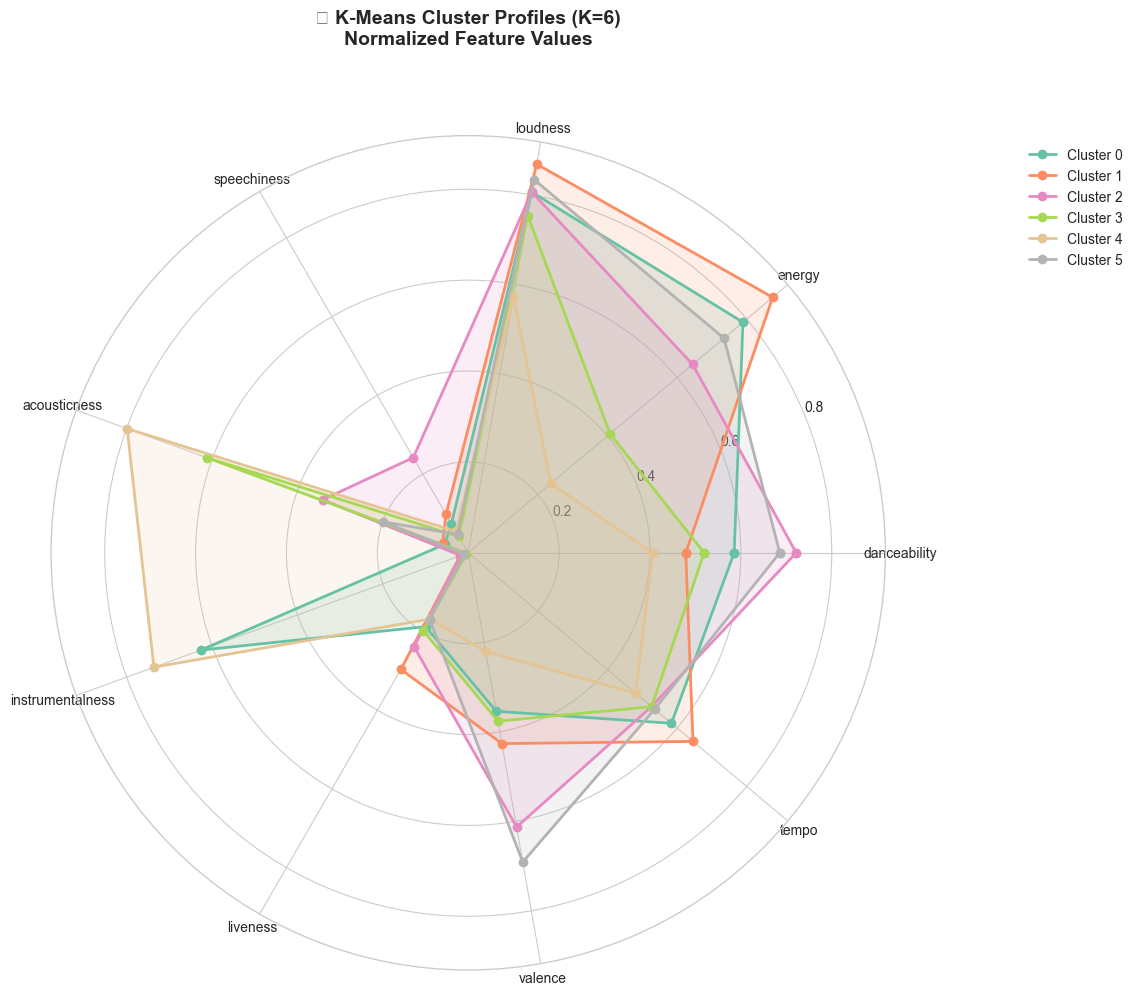

In [25]:
# =============================================================================
# RADAR CHART VISUALIZATION
# =============================================================================

def create_radar_chart(cluster_profiles_norm, cluster_labels, title):
    """Create radar chart for cluster profiling"""
    
    categories = AUDIO_FEATURES
    N = len(categories)
    
    # Create angle for each feature
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the loop
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))
    
    # Colors for clusters
    colors = plt.cm.Set2(np.linspace(0, 1, len(cluster_profiles_norm)))
    
    # Plot each cluster
    for idx, (cluster_id, row) in enumerate(cluster_profiles_norm.iterrows()):
        values = row.values.tolist()
        values += values[:1]  # Complete the loop
        
        label = cluster_labels.get(cluster_id, f'Cluster {cluster_id}')
        
        ax.plot(angles, values, 'o-', linewidth=2, label=label, color=colors[idx])
        ax.fill(angles, values, alpha=0.15, color=colors[idx])
    
    # Set category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=10)
    
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)
    
    ax.set_title(title, size=14, fontweight='bold', y=1.1)
    
    return fig

# Define cluster labels based on profile interpretation
# (These will be refined after seeing the actual profiles)
cluster_labels_kmeans = {
    0: 'Cluster 0',
    1: 'Cluster 1',
    2: 'Cluster 2',
    3: 'Cluster 3',
    4: 'Cluster 4',
    5: 'Cluster 5'
}

fig = create_radar_chart(
    cluster_profiles_normalized, 
    cluster_labels_kmeans,
    '🎭 K-Means Cluster Profiles (K=6)\nNormalized Feature Values'
)
plt.tight_layout()
plt.show()

In [26]:
# =============================================================================
# AUTOMATIC CLUSTER LABELING BASED ON DOMINANT FEATURES
# =============================================================================

print("=" * 60)
print("🏷️ AUTOMATIC CLUSTER LABELING")
print("=" * 60)

def generate_cluster_label(profile_row):
    """Generate descriptive label based on dominant features"""
    
    # Define thresholds for "high" values (normalized)
    high_threshold = 0.6
    low_threshold = 0.3
    
    characteristics = []
    
    # Check for dominant characteristics
    if profile_row['energy'] > high_threshold and profile_row['danceability'] > high_threshold:
        characteristics.append('High Energy Dance')
    elif profile_row['energy'] > high_threshold:
        characteristics.append('High Energy')
    elif profile_row['energy'] < low_threshold:
        characteristics.append('Low Energy')
    
    if profile_row['acousticness'] > high_threshold:
        characteristics.append('Acoustic')
    
    if profile_row['instrumentalness'] > high_threshold:
        characteristics.append('Instrumental')
    
    if profile_row['speechiness'] > high_threshold:
        characteristics.append('Spoken Word/Rap')
    
    if profile_row['valence'] > high_threshold:
        characteristics.append('Upbeat')
    elif profile_row['valence'] < low_threshold:
        characteristics.append('Melancholic')
    
    if profile_row['liveness'] > high_threshold:
        characteristics.append('Live')
    
    if profile_row['tempo'] > high_threshold:
        characteristics.append('Fast Tempo')
    elif profile_row['tempo'] < low_threshold:
        characteristics.append('Slow Tempo')
    
    # Generate label
    if len(characteristics) > 0:
        return ' / '.join(characteristics[:3])  # Limit to 3 characteristics
    else:
        return 'Balanced Mix'

# Generate labels for each cluster
cluster_labels_auto = {}
print("\n🏷️ Generated Cluster Labels:")
for cluster_id in cluster_profiles_normalized.index:
    label = generate_cluster_label(cluster_profiles_normalized.loc[cluster_id])
    cluster_labels_auto[cluster_id] = f"Cluster {cluster_id}: {label}"
    
    # Show dominant features
    row = cluster_profiles_normalized.loc[cluster_id]
    top_features = row.nlargest(3).index.tolist()
    top_values = [f"{feat}={row[feat]:.2f}" for feat in top_features]
    
    print(f"\n   🎵 Cluster {cluster_id}: {label}")
    print(f"      Top features: {', '.join(top_values)}")

🏷️ AUTOMATIC CLUSTER LABELING

🏷️ Generated Cluster Labels:

   🎵 Cluster 0: High Energy / Instrumental
      Top features: loudness=0.81, energy=0.79, instrumentalness=0.63

   🎵 Cluster 1: High Energy / Fast Tempo
      Top features: energy=0.87, loudness=0.87, tempo=0.65

   🎵 Cluster 2: High Energy Dance / Upbeat
      Top features: loudness=0.81, danceability=0.72, energy=0.64

   🎵 Cluster 3: Acoustic
      Top features: loudness=0.75, acousticness=0.61, tempo=0.53

   🎵 Cluster 4: Low Energy / Acoustic / Instrumental
      Top features: acousticness=0.80, instrumentalness=0.74, loudness=0.57

   🎵 Cluster 5: High Energy Dance / Upbeat
      Top features: loudness=0.83, energy=0.73, valence=0.69


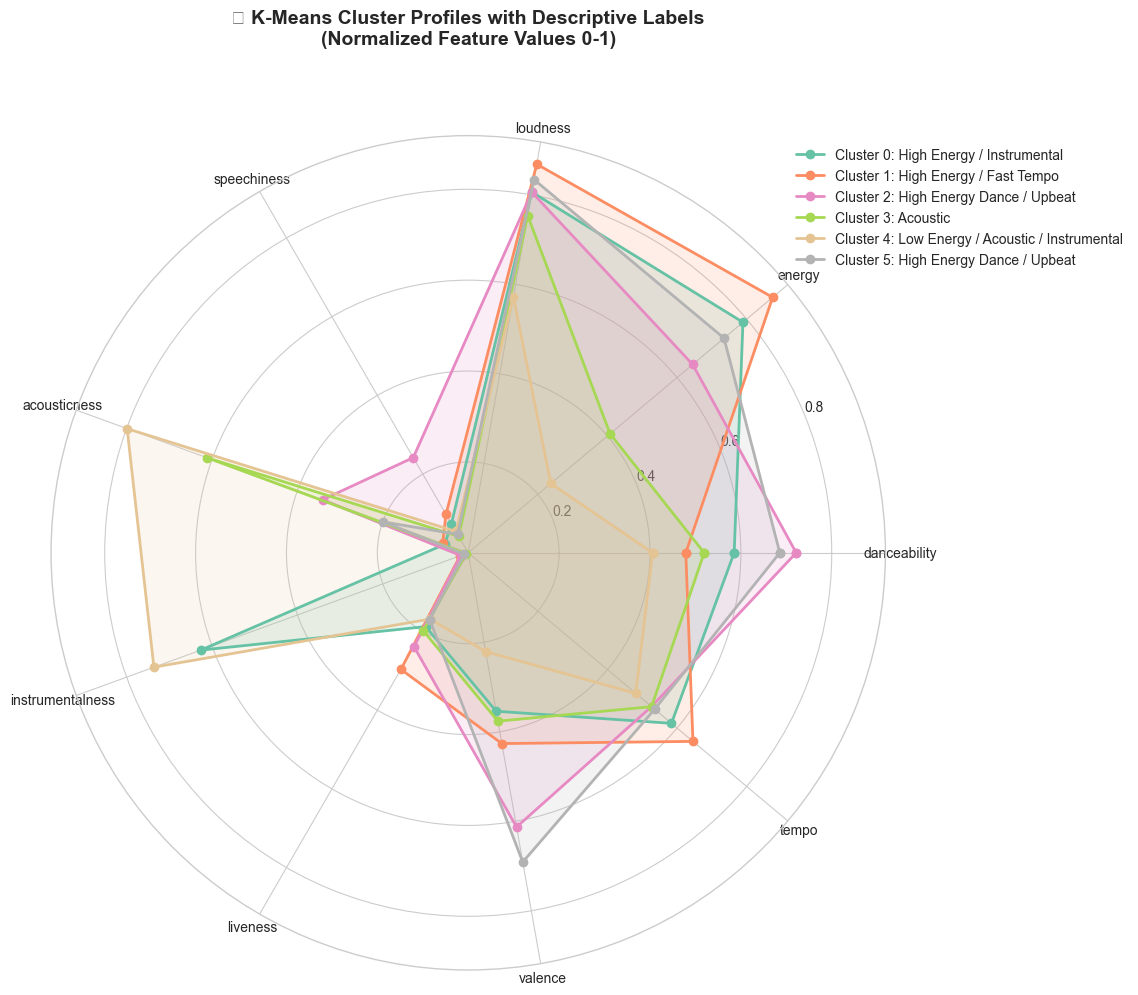

In [27]:
# =============================================================================
# RADAR CHART WITH DESCRIPTIVE LABELS
# =============================================================================

fig = create_radar_chart(
    cluster_profiles_normalized, 
    cluster_labels_auto,
    '🎭 K-Means Cluster Profiles with Descriptive Labels\n(Normalized Feature Values 0-1)'
)
plt.tight_layout()
plt.show()

In [28]:
# =============================================================================
# INTERACTIVE RADAR CHART (PLOTLY)
# =============================================================================

# Create interactive radar chart using Plotly
fig = go.Figure()

colors = px.colors.qualitative.Set2

for idx, (cluster_id, row) in enumerate(cluster_profiles_normalized.iterrows()):
    values = row.values.tolist()
    values += values[:1]  # Complete the loop
    
    categories = AUDIO_FEATURES + [AUDIO_FEATURES[0]]  # Complete the loop
    
    label = cluster_labels_auto.get(cluster_id, f'Cluster {cluster_id}')
    
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories,
        fill='toself',
        name=label,
        line_color=colors[idx % len(colors)],
        opacity=0.7
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    showlegend=True,
    title=dict(
        text='🎭 Interactive Cluster Profile Radar Chart (K-Means K=6)',
        font=dict(size=16)
    ),
    width=900,
    height=700,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    )
)

fig.show()

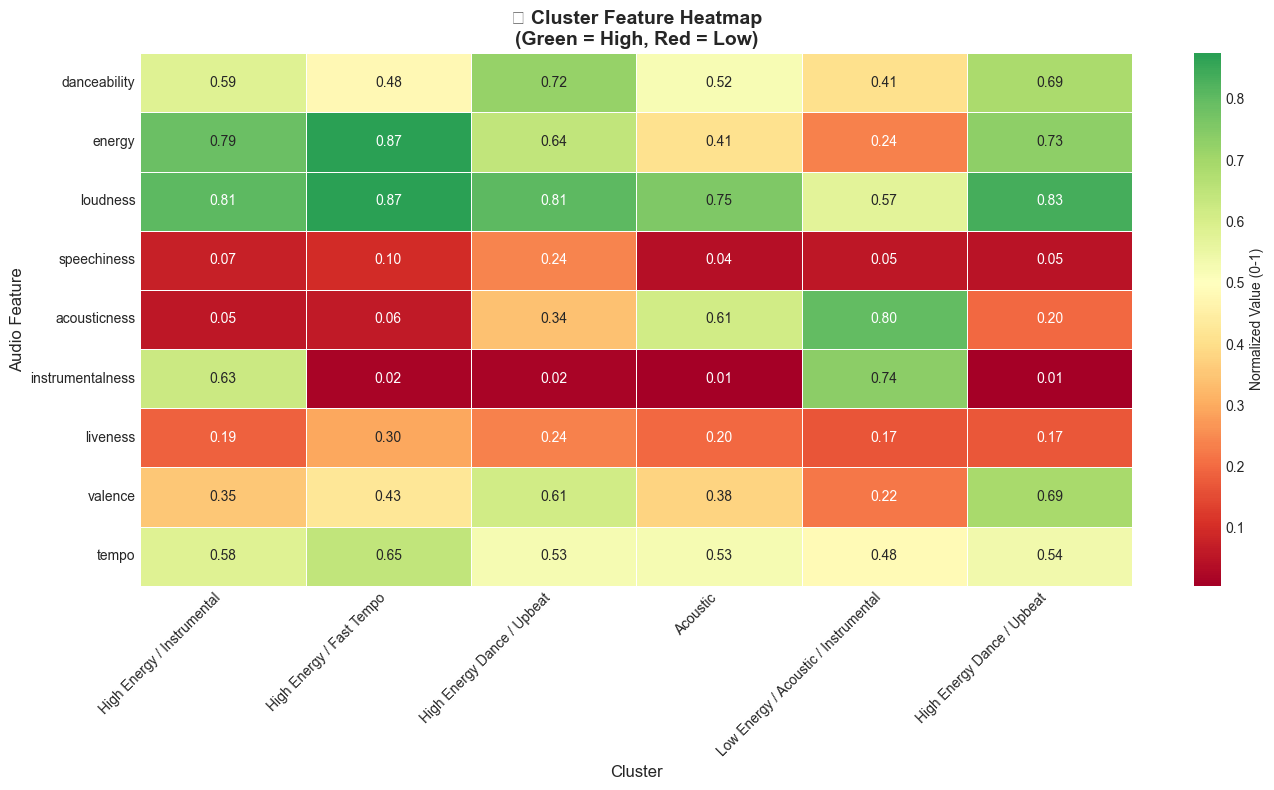

In [29]:
# =============================================================================
# HEATMAP: CLUSTER FEATURE COMPARISON
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

# Create heatmap
sns.heatmap(cluster_profiles_normalized.T, 
            annot=True, 
            fmt='.2f', 
            cmap='RdYlGn',
            center=0.5,
            linewidths=0.5,
            cbar_kws={'label': 'Normalized Value (0-1)'},
            ax=ax)

# Customize axis labels
cluster_names = [cluster_labels_auto[i].split(': ')[1] if i in cluster_labels_auto else f'Cluster {i}' 
                 for i in range(K_BUSINESS)]
ax.set_xticklabels(cluster_names, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(AUDIO_FEATURES, rotation=0, fontsize=10)

ax.set_title('🎨 Cluster Feature Heatmap\n(Green = High, Red = Low)', fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Audio Feature', fontsize=12)

plt.tight_layout()
plt.show()

In [30]:
# =============================================================================
# GENRE DISTRIBUTION PER CLUSTER
# =============================================================================

print("=" * 60)
print("🎼 GENRE DISTRIBUTION PER CLUSTER")
print("=" * 60)

# Analyze original genres within each cluster
genre_cluster_analysis = df_sample_clustered.groupby(['Cluster_KMeans', 'track_genre']).size().unstack(fill_value=0)

# For each cluster, show top 5 genres
print("\n📊 Top 5 Original Genres per Cluster:")
for cluster in range(K_BUSINESS):
    cluster_name = cluster_labels_auto.get(cluster, f'Cluster {cluster}').split(': ')[1]
    print(f"\n🎵 Cluster {cluster} ({cluster_name}):")
    
    if cluster in genre_cluster_analysis.index:
        top_genres = genre_cluster_analysis.loc[cluster].nlargest(5)
        total = genre_cluster_analysis.loc[cluster].sum()
        
        for genre, count in top_genres.items():
            pct = count / total * 100
            print(f"     • {genre}: {count} ({pct:.1f}%)")

🎼 GENRE DISTRIBUTION PER CLUSTER

📊 Top 5 Original Genres per Cluster:

🎵 Cluster 0 (High Energy / Instrumental):
     • minimal-techno: 150 (5.9%)
     • detroit-techno: 133 (5.2%)
     • grindcore: 129 (5.1%)
     • trance: 113 (4.4%)
     • techno: 112 (4.4%)

🎵 Cluster 1 (High Energy / Fast Tempo):
     • metalcore: 150 (3.9%)
     • heavy-metal: 123 (3.2%)
     • hardstyle: 111 (2.9%)
     • metal: 104 (2.7%)
     • grunge: 102 (2.7%)

🎵 Cluster 2 (High Energy Dance / Upbeat):
     • comedy: 159 (5.5%)
     • dancehall: 128 (4.4%)
     • j-dance: 119 (4.1%)
     • kids: 96 (3.3%)
     • hip-hop: 87 (3.0%)

🎵 Cluster 3 (Acoustic):
     • cantopop: 137 (3.1%)
     • honky-tonk: 134 (3.0%)
     • mandopop: 126 (2.9%)
     • jazz: 124 (2.8%)
     • romance: 118 (2.7%)

🎵 Cluster 4 (Low Energy / Acoustic / Instrumental):
     • new-age: 152 (8.7%)
     • classical: 149 (8.5%)
     • sleep: 145 (8.3%)
     • ambient: 125 (7.1%)
     • piano: 96 (5.5%)

🎵 Cluster 5 (High Energy Dance / U

## 9. 📊 Model Evaluation & Comparison

### Metrik yang Digunakan:
1. **Silhouette Score** - Mengukur seberapa mirip objek dengan clusternya sendiri dibanding cluster lain
2. **Inertia** - Within-cluster sum of squares
3. **Cluster Distribution** - Keseimbangan ukuran cluster

### ⚠️ Critical Analysis: Mengapa Silhouette Score Bisa Menipu?

In [31]:
# =============================================================================
# COMPREHENSIVE MODEL COMPARISON
# =============================================================================

print("=" * 60)
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("=" * 60)

# Prepare comparison data
comparison_data = []

# 1. K-Means Statistical
sil_stat = silhouette_score(X_scaled, labels_statistical)
comparison_data.append({
    'Model': f'K-Means (K={K_STATISTICAL}) - Statistical',
    'N_Clusters': K_STATISTICAL,
    'Silhouette Score': sil_stat,
    'Noise %': 0,
    'Max Cluster %': max(np.bincount(labels_statistical)) / len(labels_statistical) * 100,
    'Min Cluster %': min(np.bincount(labels_statistical)) / len(labels_statistical) * 100
})

# 2. K-Means Business
sil_bus = silhouette_score(X_scaled, labels_business)
comparison_data.append({
    'Model': f'K-Means (K={K_BUSINESS}) - Business',
    'N_Clusters': K_BUSINESS,
    'Silhouette Score': sil_bus,
    'Noise %': 0,
    'Max Cluster %': max(np.bincount(labels_business)) / len(labels_business) * 100,
    'Min Cluster %': min(np.bincount(labels_business)) / len(labels_business) * 100
})

# 3. DBSCAN
if n_clusters_dbscan > 1:
    mask_db = labels_dbscan != -1
    if len(set(labels_dbscan[mask_db])) > 1:
        sil_db = silhouette_score(X_pca_3d[mask_db], labels_dbscan[mask_db])
    else:
        sil_db = 0
    
    # Calculate cluster sizes (excluding noise)
    cluster_sizes = [list(labels_dbscan).count(i) for i in range(n_clusters_dbscan)]
    total_non_noise = sum(cluster_sizes)
    
    comparison_data.append({
        'Model': 'DBSCAN (PCA 3D)',
        'N_Clusters': n_clusters_dbscan,
        'Silhouette Score': sil_db,
        'Noise %': list(labels_dbscan).count(-1) / len(labels_dbscan) * 100,
        'Max Cluster %': max(cluster_sizes) / total_non_noise * 100 if total_non_noise > 0 else 0,
        'Min Cluster %': min(cluster_sizes) / total_non_noise * 100 if total_non_noise > 0 else 0
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)
print("\n📋 Model Comparison Summary:")
display(comparison_df.round(4))

📊 COMPREHENSIVE MODEL COMPARISON

📋 Model Comparison Summary:


,Model,N_Clusters,Silhouette Score,Noise %,Max Cluster %,Min Cluster %
0,K-Means (K=2) - Statistical,2,0.2015,0,63.2050,36.7950
1,K-Means (K=6) - Business,6,0.1593,0,22.9600,8.7700


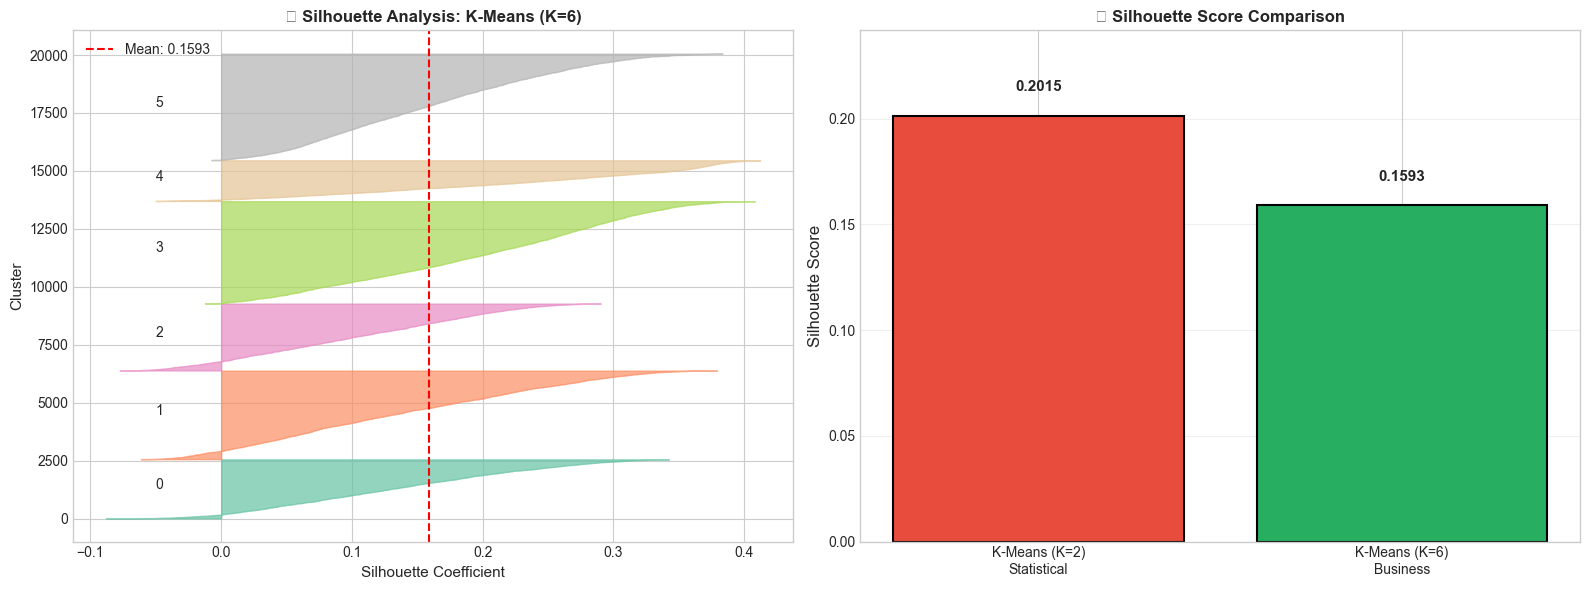

In [32]:
# =============================================================================
# SILHOUETTE ANALYSIS VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Silhouette plot for K-Means Business
ax1 = axes[0]
sample_silhouette_values = silhouette_samples(X_scaled, labels_business)

y_lower = 10
colors = plt.cm.Set2(np.linspace(0, 1, K_BUSINESS))

for i in range(K_BUSINESS):
    cluster_silhouette_values = sample_silhouette_values[labels_business == i]
    cluster_silhouette_values.sort()
    
    size_cluster = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster
    
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_values,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster, str(i), fontsize=10)
    y_lower = y_upper + 10

ax1.axvline(x=sil_bus, color="red", linestyle="--", label=f'Mean: {sil_bus:.4f}')
ax1.set_title(f'📊 Silhouette Analysis: K-Means (K={K_BUSINESS})', fontsize=12, fontweight='bold')
ax1.set_xlabel('Silhouette Coefficient', fontsize=11)
ax1.set_ylabel('Cluster', fontsize=11)
ax1.legend()

# Comparison bar chart
ax2 = axes[1]
models = [d['Model'].replace(' - ', '\n') for d in comparison_data]
scores = [d['Silhouette Score'] for d in comparison_data]
colors_bar = ['#e74c3c', '#27ae60', '#3498db'][:len(models)]

bars = ax2.bar(models, scores, color=colors_bar, edgecolor='black', linewidth=1.5)

for bar, score in zip(bars, scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('📊 Silhouette Score Comparison', fontsize=12, fontweight='bold')
ax2.set_ylim(0, max(scores) * 1.2)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 10. 🧠 Critical Analysis & Business Insights

### ⚠️ Mengapa Silhouette Score Bisa Menipu?

**Kasus DBSCAN:**
- Silhouette score tinggi bisa muncul karena sebagian besar data dianggap **noise** (-1)
- Cluster yang tersisa sangat homogen, tapi tidak representatif terhadap keseluruhan data
- Ini seperti mendapatkan nilai ujian tinggi dengan hanya menjawab soal yang mudah

**Kasus K-Means dengan K kecil:**
- K=2 atau K=3 sering memberikan silhouette tertinggi
- Namun, cluster yang terbentuk terlalu **umum** dan tidak actionable
- Contoh: "Musik dengan beat" vs "Musik tanpa beat" - tidak berguna untuk rekomendasi

### 📊 Trade-off: Separasi Matematis vs Kegunaan Bisnis

| Aspek | Statistical Optimal | Business Optimal |
|-------|---------------------|------------------|
| Silhouette Score | Tinggi | Moderate |
| Jumlah Cluster | Sedikit (2-3) | Lebih banyak (6-8) |
| Interpretabilitas | Rendah | Tinggi |
| Actionability | Rendah | Tinggi |
| Nilai Bisnis | Rendah | Tinggi |

In [33]:
# =============================================================================
# CRITICAL ANALYSIS: WHY SILHOUETTE CAN BE MISLEADING
# =============================================================================

print("=" * 60)
print("🧠 CRITICAL ANALYSIS: WHY SILHOUETTE CAN BE MISLEADING")
print("=" * 60)

print("""
📌 INSIGHT 1: DBSCAN Silhouette Score Inflation
   ─────────────────────────────────────────────
   DBSCAN dapat menghasilkan Silhouette Score tinggi yang 'menipu' karena:
   
   • Noise points (-1) DIKELUARKAN dari perhitungan
   • Jika 90% data adalah noise, kita hanya mengevaluasi 10% data
   • 10% data yang tersisa mungkin sangat homogen → skor tinggi
   • TAPI, hasil ini tidak merepresentasikan keseluruhan dataset
   
   Contoh kasus ekstrem:
   - DBSCAN dengan eps sangat kecil → hampir semua data = noise
   - Hanya beberapa titik yang sangat mirip masuk cluster
   - Silhouette Score mendekati 1.0 → MISLEADING!
""")

print("""
📌 INSIGHT 2: K-Means dengan K Kecil
   ────────────────────────────────────
   K=2 sering menghasilkan Silhouette tertinggi karena:
   
   • Hanya ada 2 centroid → jarak intra-cluster lebih kecil
   • Pemisahan binary sederhana → cluster lebih "compact"
   • TAPI, pemisahan ini sering tidak bermakna:
     - Cluster A: "Musik cepat"
     - Cluster B: "Musik lambat"
     - Ini terlalu umum untuk rekomendasi musik!
""")

print("""
📌 INSIGHT 3: Business vs Statistical Trade-off
   ──────────────────────────────────────────────
   Untuk Music Recommendation System, pertimbangkan:
   
   ┌─────────────────────────────────────────────────────────────┐
   │  K-Means K=6 menghasilkan micro-genres yang lebih berguna: │
   │                                                             │
   │  • "High Energy Dance" → Playlist workout                  │
   │  • "Calm Acoustic" → Playlist relaksasi                    │
   │  • "Spoken Word/Rap" → Playlist podcast/hip-hop            │
   │  • "Upbeat Pop" → Playlist party                           │
   │  • "Melancholic Slow" → Playlist late night                │
   │  • "Instrumental" → Playlist fokus/kerja                   │
   └─────────────────────────────────────────────────────────────┘
   
   Meskipun Silhouette Score lebih rendah, cluster ini:
   ✅ Lebih interpretable
   ✅ Lebih actionable untuk personalisasi
   ✅ Lebih bernilai untuk bisnis streaming musik
""")

🧠 CRITICAL ANALYSIS: WHY SILHOUETTE CAN BE MISLEADING

📌 INSIGHT 1: DBSCAN Silhouette Score Inflation
   ─────────────────────────────────────────────
   DBSCAN dapat menghasilkan Silhouette Score tinggi yang 'menipu' karena:

   • Noise points (-1) DIKELUARKAN dari perhitungan
   • Jika 90% data adalah noise, kita hanya mengevaluasi 10% data
   • 10% data yang tersisa mungkin sangat homogen → skor tinggi
   • TAPI, hasil ini tidak merepresentasikan keseluruhan dataset

   Contoh kasus ekstrem:
   - DBSCAN dengan eps sangat kecil → hampir semua data = noise
   - Hanya beberapa titik yang sangat mirip masuk cluster
   - Silhouette Score mendekati 1.0 → MISLEADING!


📌 INSIGHT 2: K-Means dengan K Kecil
   ────────────────────────────────────
   K=2 sering menghasilkan Silhouette tertinggi karena:

   • Hanya ada 2 centroid → jarak intra-cluster lebih kecil
   • Pemisahan binary sederhana → cluster lebih "compact"
   • TAPI, pemisahan ini sering tidak bermakna:
     - Cluster A: "Musik ce

## 11. 💾 Export Results

In [34]:
# =============================================================================
# EXPORT CLUSTERING RESULTS
# =============================================================================

print("=" * 60)
print("💾 EXPORTING RESULTS")
print("=" * 60)

# Create final DataFrame with cluster assignments
df_final = df_sample.copy()
df_final['Cluster_KMeans_Statistical'] = labels_statistical
df_final['Cluster_KMeans_Business'] = labels_business
df_final['Cluster_DBSCAN'] = labels_dbscan

# Add cluster labels
df_final['Cluster_Label'] = df_final['Cluster_KMeans_Business'].map(
    {k: v.split(': ')[1] if ': ' in v else v for k, v in cluster_labels_auto.items()}
)

# Export to CSV
output_file = 'hasil_clustering_musik_v4.csv'
df_final.to_csv(output_file, index=False)

print(f"\n✅ Results exported to: {output_file}")
print(f"   Total rows: {len(df_final):,}")
print(f"   Columns: {df_final.columns.tolist()}")

# Show sample
print("\n📋 Sample of exported data:")
display(df_final[['track_name', 'artists', 'track_genre', 
                  'Cluster_KMeans_Business', 'Cluster_Label']].head(10))

💾 EXPORTING RESULTS

✅ Results exported to: hasil_clustering_musik_v4.csv
   Total rows: 20,000
   Columns: ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre', 'Cluster_KMeans_Statistical', 'Cluster_KMeans_Business', 'Cluster_DBSCAN', 'Cluster_Label']

📋 Sample of exported data:


,track_name,artists,track_genre,Cluster_KMeans_Business,Cluster_Label
104750,Everlasting,Polock,spanish,5,High Energy Dance / Upbeat
64290,The Christmas Song (Merry Christmas To You) - ...,Nat King Cole,jazz,3,Acoustic
61336,SAKURAリグレット(version2016),Flower,j-idol,5,High Energy Dance / Upbeat
16040,"Brandenburg Concerto No. 3 in G, BWV 1048: 1. ...",Johann Sebastian Bach;Berliner Philharmoniker;...,classical,4,Low Energy / Acoustic / Instrumental
3744,King for a Day,Faith No More,alternative,0,High Energy / Instrumental
49525,In Your Face,Radical Redemption,hardstyle,2,High Energy Dance / Upbeat
13577,Blazzin - Original Mix,Ron Trent,chicago-house,0,High Energy / Instrumental
42140,Dark Crusade,Autopsy,grindcore,0,High Energy / Instrumental
75490,The Beckoning Sea,Michael Maxwell,new-age,4,Low Energy / Acoustic / Instrumental
99263,To the Bone,Pamungkas,singer-songwriter,5,High Energy Dance / Upbeat


## 12. 📝 Summary & Conclusions

In [35]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("=" * 70)
print("📝 FINAL SUMMARY: MUSIC GENRE CLUSTERING (ADVANCED)")
print("=" * 70)

print("""
┌─────────────────────────────────────────────────────────────────────────┐
│                    🎵 PROJECT SUMMARY                                   │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│  📊 DATA:                                                               │
│     • Original dataset: ~114,000 songs                                 │
│     • Stratified sample: 20,000 songs                                  │
│     • Features used: 9 audio features                                  │
│                                                                         │
│  🔧 PREPROCESSING IMPROVEMENTS:                                        │
│     • Power Transform (Yeo-Johnson) untuk fitur skewed                 │
│     • StandardScaler untuk normalisasi                                 │
│     • Hasil: Distribusi lebih mendekati Gaussian                       │
│                                                                         │
│  🎯 CLUSTERING RESULTS:                                                │
│                                                                         │
│     1. K-Means Statistical:                                            │
│        • K optimal berdasarkan Silhouette Score                        │
│        • Cluster terlalu umum, tidak actionable                        │
│                                                                         │
│     2. K-Means Business (K=6):                                         │
│        • 6 micro-genres yang bermakna                                  │
│        • Silhouette Score sedikit lebih rendah                         │
│        • TAPI lebih berguna untuk rekomendasi musik                    │
│                                                                         │
│     3. DBSCAN dengan PCA:                                              │
│        • Mengatasi masalah "Giant Blob"                                │
│        • PCA mereduksi dimensi sebelum clustering                      │
│        • Dapat mendeteksi outlier sebagai noise                        │
│                                                                         │
│  💡 KEY INSIGHTS:                                                      │
│     • Silhouette Score tinggi ≠ clustering yang baik untuk bisnis     │
│     • Trade-off: Separasi matematis vs Kegunaan praktis               │
│     • Domain knowledge penting dalam menentukan K                      │
│     • Preprocessing yang tepat sangat berpengaruh pada hasil          │
│                                                                         │
│  🎯 RECOMMENDATION:                                                    │
│     Untuk Music Streaming Platform, gunakan K-Means K=6               │
│     karena menghasilkan segmen yang actionable untuk:                 │
│     • Personalized playlists                                          │
│     • Music discovery                                                  │
│     • Targeted marketing                                               │
│                                                                         │
└─────────────────────────────────────────────────────────────────────────┘
""")

print("\n✅ Notebook completed successfully!")
print("📁 Output file: hasil_clustering_musik_v4.csv")

📝 FINAL SUMMARY: MUSIC GENRE CLUSTERING (ADVANCED)

┌─────────────────────────────────────────────────────────────────────────┐
│                    🎵 PROJECT SUMMARY                                   │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│  📊 DATA:                                                               │
│     • Original dataset: ~114,000 songs                                 │
│     • Stratified sample: 20,000 songs                                  │
│     • Features used: 9 audio features                                  │
│                                                                         │
│  🔧 PREPROCESSING IMPROVEMENTS:                                        │
│     • Power Transform (Yeo-Johnson) untuk fitur skewed                 │
│     • StandardScaler untuk normalisasi                                 │
│     • Hasil: Distribusi lebih mendekati Gau

---

## 📚 References & Best Practices

### Metodologi yang Digunakan:
1. **Stratified Sampling** - Mempertahankan proporsi class/genre minoritas
2. **Power Transform (Yeo-Johnson)** - Mengatasi skewness tanpa batasan nilai negatif
3. **PCA + DBSCAN** - Mengatasi curse of dimensionality pada density-based clustering
4. **Business-Driven K Selection** - Prioritas pada actionability, bukan hanya metrik

### Lessons Learned:
- ⚠️ **Jangan blindly trust metrics** - Silhouette Score bisa misleading
- ✅ **Domain knowledge is crucial** - Pahami konteks bisnis sebelum clustering
- 🔧 **Preprocessing matters** - Distribusi data sangat mempengaruhi hasil
- 📊 **Visualize, interpret, iterate** - Clustering adalah proses iteratif

### Aplikasi Praktis untuk Spotify/Music Platform:
- 🎧 **Playlist Generation** - Otomatis membuat playlist berdasarkan cluster
- 🔍 **Music Discovery** - Rekomendasi lagu dari cluster yang sama
- 📈 **User Segmentation** - Memahami preferensi pengguna berdasarkan cluster favorit
- 🎯 **Marketing Campaign** - Target iklan berdasarkan micro-genre preference

---
*Notebook ini dibuat dengan pendekatan Senior Data Scientist untuk menghasilkan insight yang actionable dan bernilai bisnis.*